In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare
import matplotlib.colors

In [2]:
#patient_id = 'id001_bt'
patient_id = 'id003_mg'
patient_id = 'id010_cmn'
#patient_id = 'id017_mk'
data_dir = f'/home/hfw/Retro/datasets/{patient_id}'
results_dir = f'/home/hfw/Retro/results/{patient_id}'
#szr_name = 'BF_crise1P_110831B-CEX_0004'
#szr_name = 'BF_crise1P_110831B-CEX_0004'
#szr_name = "MK_crise1Part1_170328C-BEX_0004_MK_crise1Part2_170328C-BEX_0007"
#szr_name = "MK_crise2_PSG_170328C-CEX_0002"
#szr_name = 'BTcrise2appportable_0013'
#szr_name = 'BTcrise1appportable_0006'
szr_name = 'CMN_crise3P_140320b-bex_0003'
meta_data_fname = f'{szr_name}.json'
#raw_seeg_fname = f'{szr_name}.raw.fif'
fname_suffix = f'{szr_name}'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

In [3]:
hpf = 10
lpf = 0.02
raw_seeg_fname = f'{szr_name}.raw.fif'
#data_mono = retro_prepare_data.prepare_data(data_dir, meta_data_fname, raw_seeg_fname, szr_name, hpf, lpf)
#raw_seeg_fname = f'{szr_name}.bip.raw.fif'
data = retro_prepare.prepare_data_bip(data_dir, meta_data_fname, raw_seeg_fname, szr_name, hpf, lpf)
#fname_suffix += f'_hpf{hpf}_lpf{lpf}'

Isotrak not found


/opt/conda/envs/jhub/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [4]:
seeg, bip = retro_prepare.read_one_seeg(data_dir, meta_data_fname, raw_seeg_fname)
#slp = retro_prepare.compute_slp(seeg, bip, hpf, lpf)

Isotrak not found


In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
int(seeg['sfreq']*ts)

1280

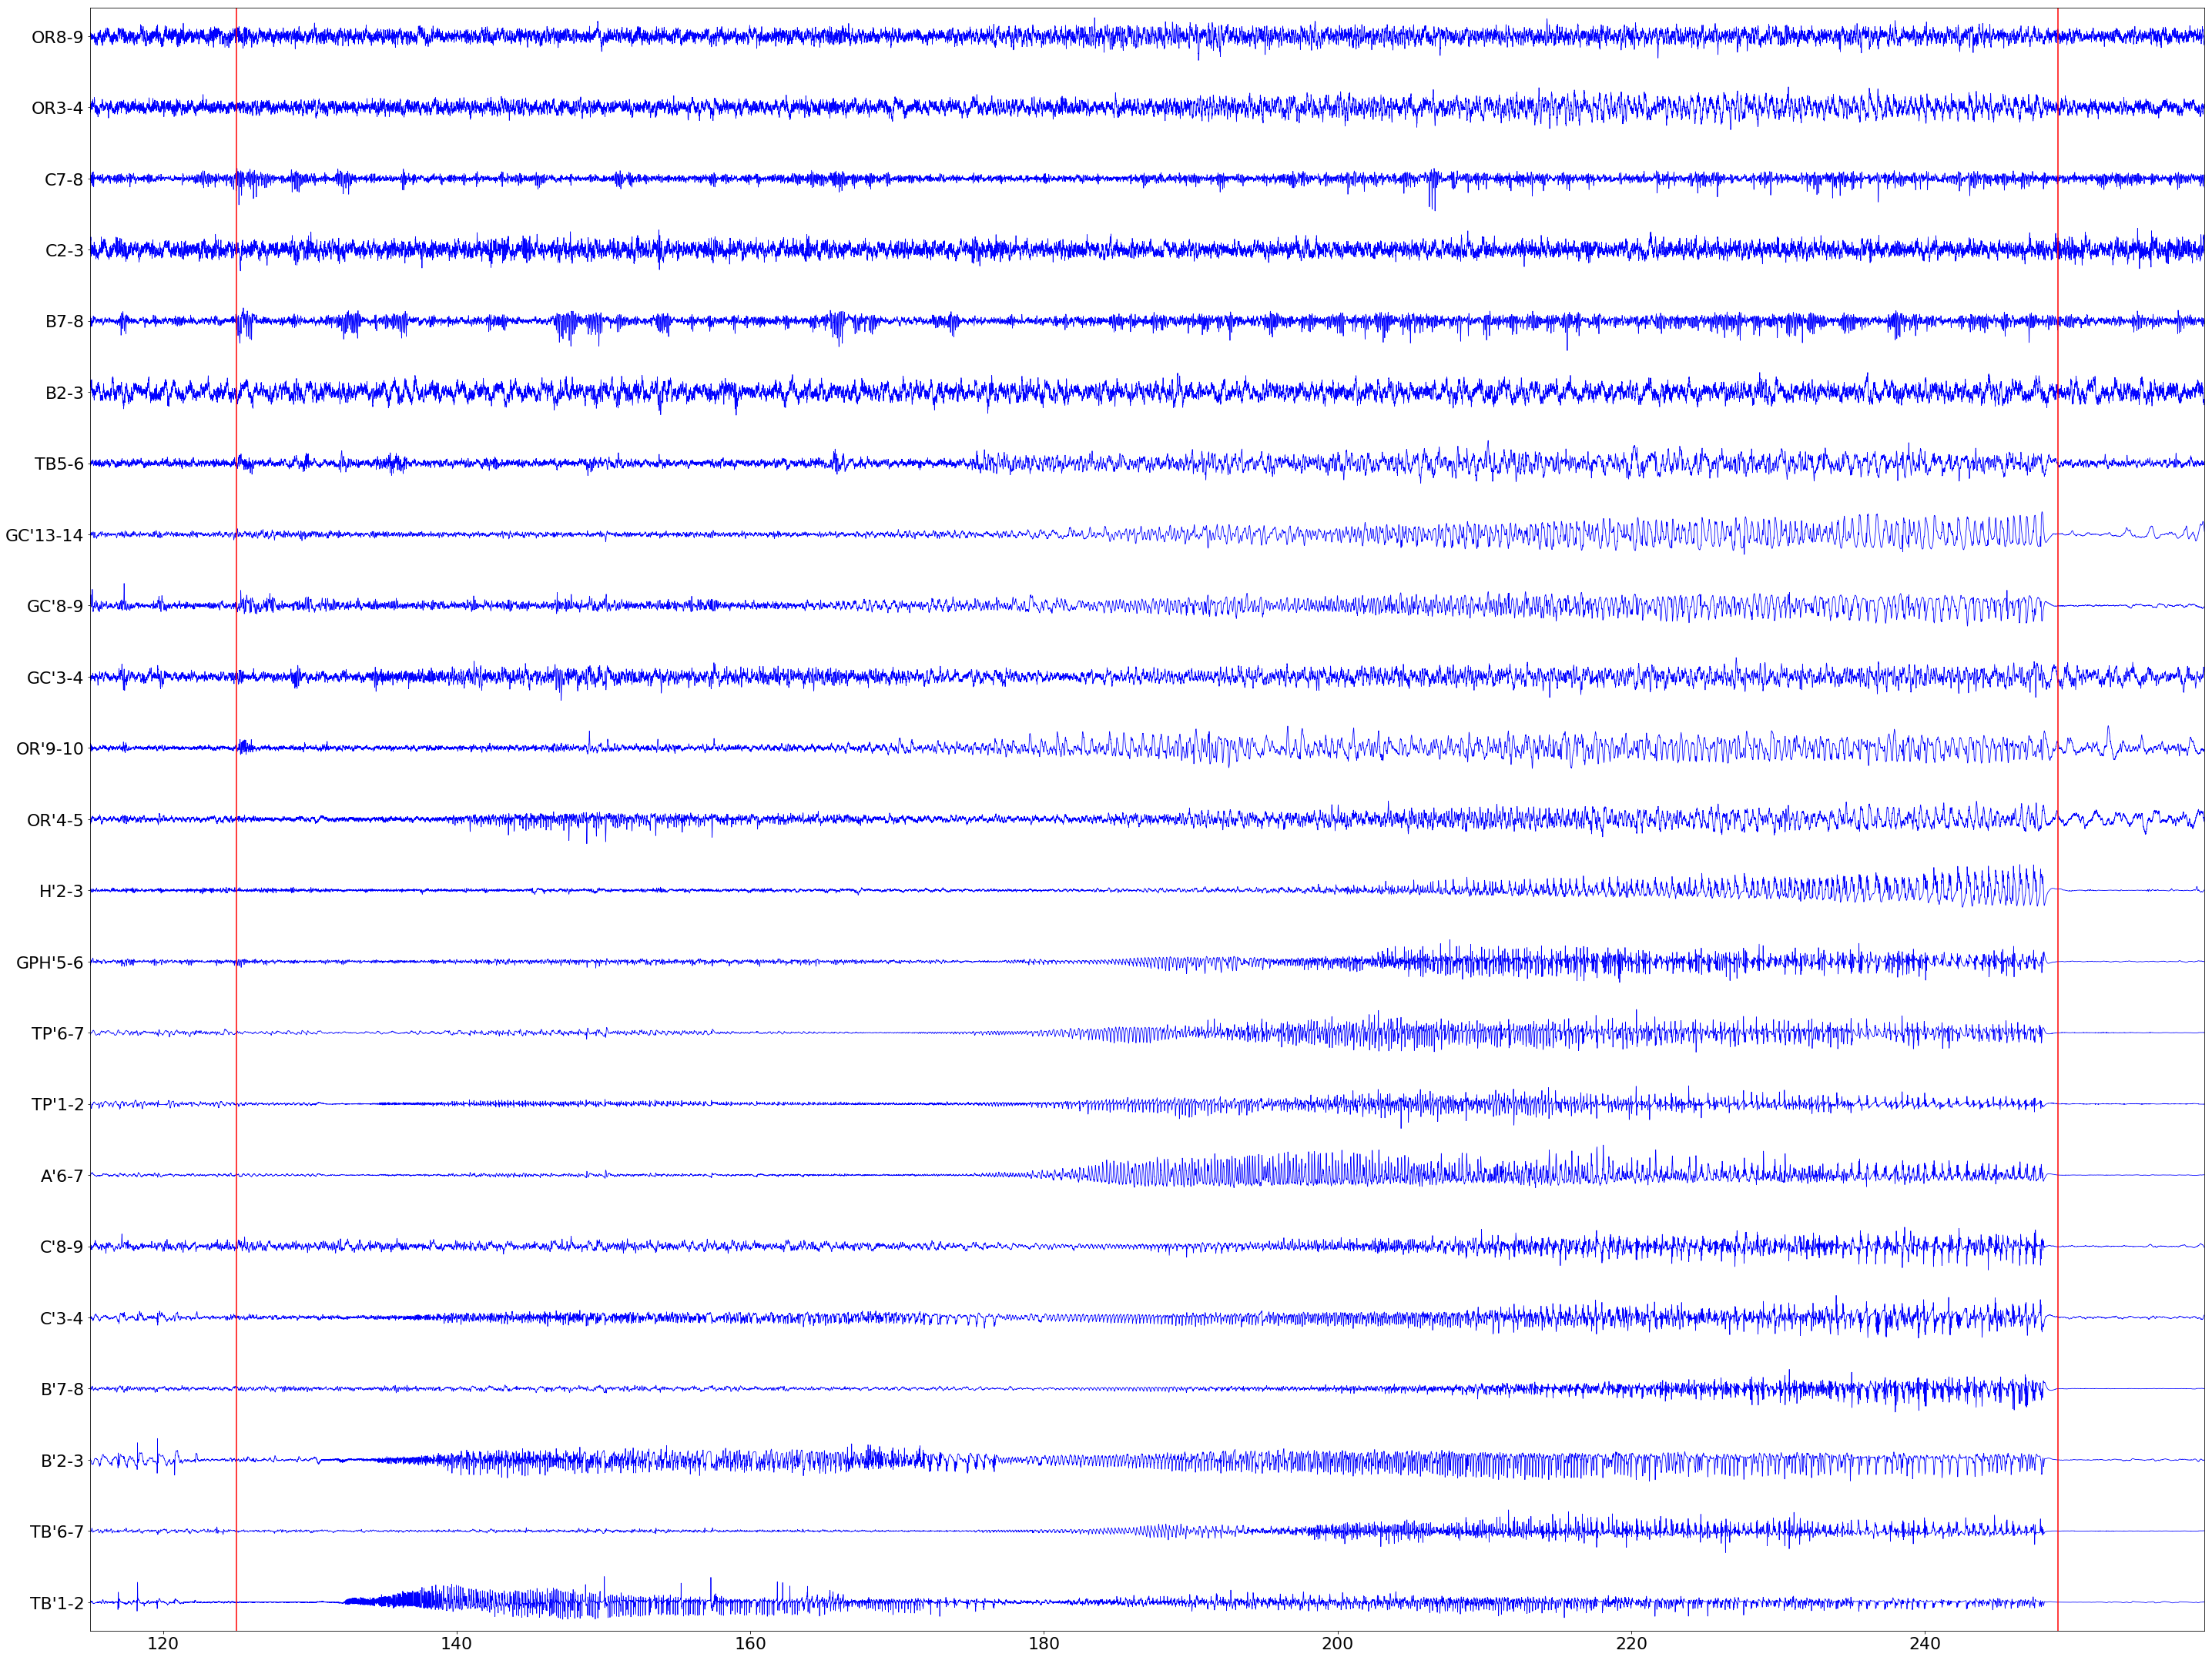

In [27]:
ts = 10
base_length = int(seeg['sfreq']*ts)

start_idx = int(seeg['onset'] * seeg['sfreq']) - base_length
end_idx = int(seeg['offset'] * seeg['sfreq']) + base_length
y = bip.get_data().T[start_idx:end_idx].T
t = bip.times[start_idx:end_idx]

figure(figsize=[40,30])
scaleplt=3
nch=np.arange(0,len(bip.ch_names),5)
Ty=np.arange(np.shape(y[0])[0])
show_ch=[]
for i in nch:
    plt.plot(t, scaleplt*y[i]/np.ptp(y[i]) + i, 'b', lw=0.8);
    show_ch.append(bip.ch_names[i])
plt.yticks(nch, show_ch, fontsize=22);
plt.xticks(fontsize=22)
plt.ylim([-2,nch[-1]+2])
plt.xlim([t[0],t[-1]])
plt.axvline(seeg['onset'], color='red')
plt.axvline(seeg['offset'],color='red')
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/ts_{patient_id}_{szr_name}_bf.png')

In [7]:
def read_ez_sens_mask(sid, ch_names):
    xlsx_file = os.path.join(sid, "patient.xlsx")
    CONTACTS_IND = 6
    EZ_IND = 7
    df = pd.read_excel(xlsx_file, sheet_name="EZ hypothesis and EI", header=1)
    ez_contacts = []
    contacts_col = df.iloc[:, CONTACTS_IND]
    mask = contacts_col.notnull()
    contacts_names = contacts_col[mask]
    ez_mask = df.iloc[:, EZ_IND][mask] == "YES"
    ez_contacts.extend(contacts_names[ez_mask])
    # OR1-OR2 -> OR1-2
    # TODO handle the case monopolar
    ez_contacts_ = []
    cre = re.compile("([A-Za-z'p]+)([0-9]+)-([A-Za-z'p]+)([0-9]+)")
    cre_mono = re.compile("([A-Za-z'p]+)([0-9]+)")
    for ez_contact in ez_contacts:
        try:
            nm, i, _, j = cre.match(ez_contact).groups()
            ez_contacts_.append(f"{nm}{i}-{j}")
        except Exception as exc:
            try:
                nm, i = cre_mono.match(ez_contact).groups()
                ez_contacts_.append(f"{nm}{i}-{int(i)+1}")
            except Exception as exc:
                print(sid, ez_contact, exc)
                continue
    m_ez = np.array([_ in ez_contacts_ for _ in ch_names])
    return m_ez

In [8]:
import mne
import pandas as pd
import re

In [9]:
#raw = retro_prepare.load_raw_fif(meta_data_fname)
'''raw = mne.io.Raw(
                os.path.join(data_dir, 'seeg', 'fif', raw_seeg_fname),
                verbose='WARNING',
                preload=True)
'''
ezh = read_ez_sens_mask(data_dir, bip.ch_names)


In [10]:
all_fb_d0=np.load(f'{results_dir}/EZdelay/ez_prior_{szr_name}.npy')
d0_prior=np.mean(all_fb_d0,axis=0)
ez_prior=np.where(d0_prior>0.5)


/opt/conda/envs/jhub/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


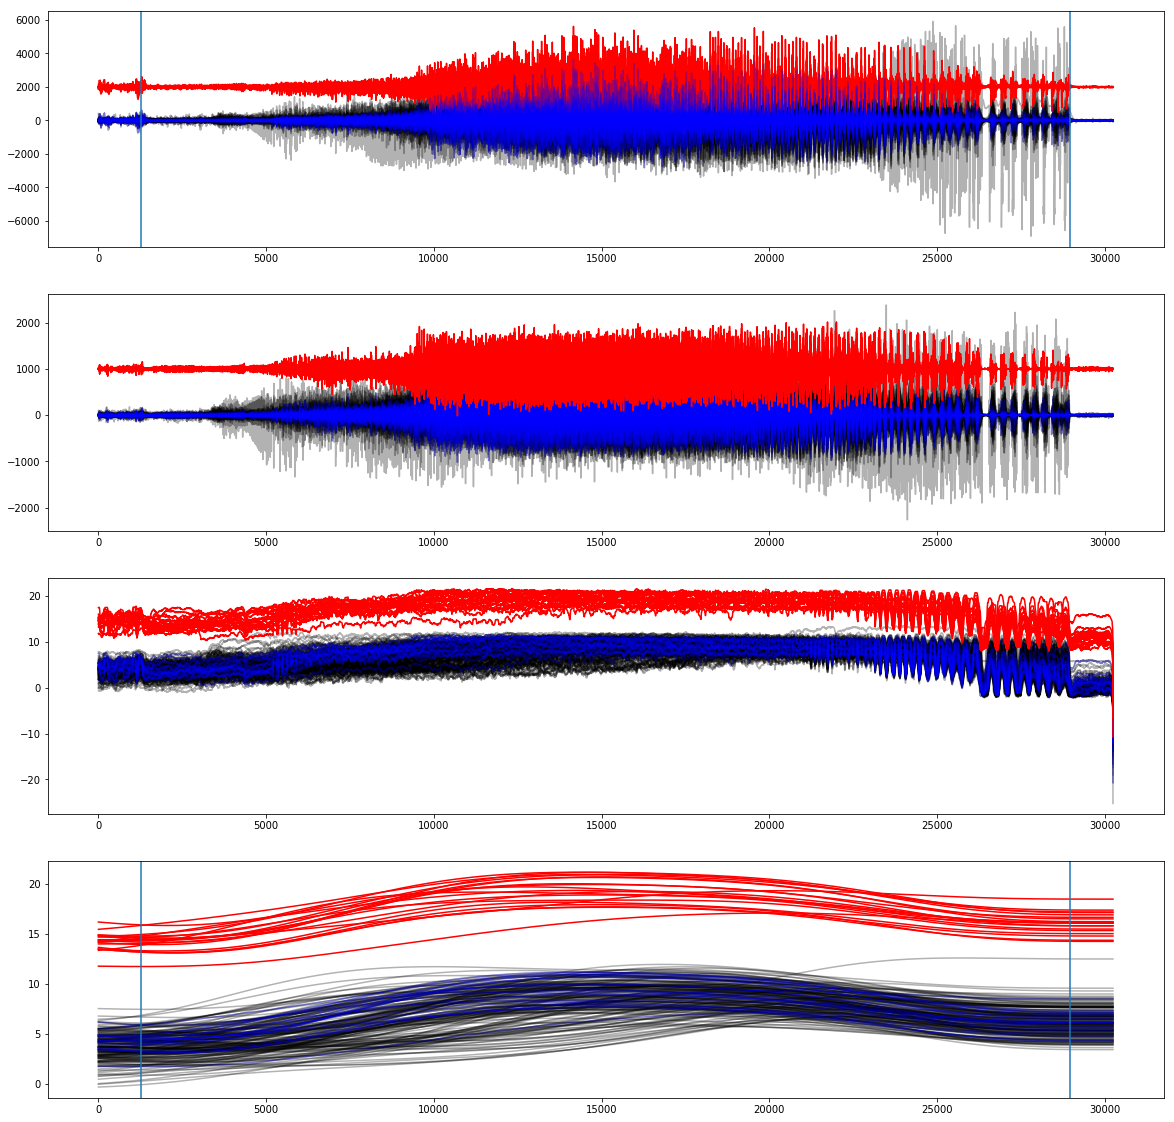

In [11]:

ts = 5
base_length = int(seeg['sfreq']*ts)

start_idx = int(seeg['onset'] * seeg['sfreq']) - base_length
end_idx = int(seeg['offset'] * seeg['sfreq']) + base_length
slp = bip.get_data().T[start_idx:end_idx]
#slp = seeg['time_series'].copy()
# Remove outliers i.e data > 2*sd
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh]+2000,color='red');
plt.plot(slp[:,ezh],color='blue', alpha = 0.3);
plt.axvline(int(seeg['sfreq']*ts))
plt.axvline(len(slp)-int(seeg['sfreq']*ts))


for i in range(slp.shape[1]):
    ts = slp[:, i]
    ts[abs(ts - ts.mean()) > 2 * ts.std()] = ts.mean()
# High pass filter the data
slp = lib.preprocess.envelope.bfilt(
    slp, seeg['sfreq'], hpf, 'highpass', axis=0)
plt.subplot(412)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh],color='blue',alpha = 0.3);
plt.plot(slp[:,ezh]+1000,color='red');

# Compute seeg log power
slp = lib.preprocess.envelope.seeg_log_power(slp, 100)
plt.subplot(413)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh],color='blue',alpha = 0.3);
plt.plot(slp[:,ezh]+10,color='red');

# Remove outliers i.e data > 2*sd
for i in range(slp.shape[1]):
    ts = slp[:, i]
    ts[abs(ts - ts.mean()) > 2 * ts.std()] = ts.mean()
# Low pass filter the data to smooth
slp = lib.preprocess.envelope.bfilt(
    slp, seeg['sfreq'], lpf, 'lowpass', axis=0)

plt.subplot(414)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh],color='blue',alpha = 0.3);
plt.plot(slp[:,ezh]+10,color='red');
plt.axvline(base_length)
plt.axvline(len(slp)-base_length)



In [12]:
import json
with open(f'../ANSM/util/data/ei-final.json','r') as f:
    ezh_all = json.load(f)
ind_ez = ezh_all[patient_id]['i_ez']
ind_pz = ezh_all[patient_id]['i_pz']

In [13]:
ds_freq = int(data['slp'].shape[0]/150)
data['slp'] = data['slp'][0:-1:ds_freq]
data['snsr_pwr'] = (data['slp']**2).mean(axis=0)
data['ns'], data['nn'] = data['gain'].shape
data['nt'] = data['slp'].shape[0]
ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.vep.txt') == 1)[0]
data['x0_mu'] = -3.0*np.ones(data['nn'])
fname_suffix += f'_hpf{hpf}_lpf{lpf}_ezdelay'
data['x0_mu'][ez_prior[0]] = -1.5

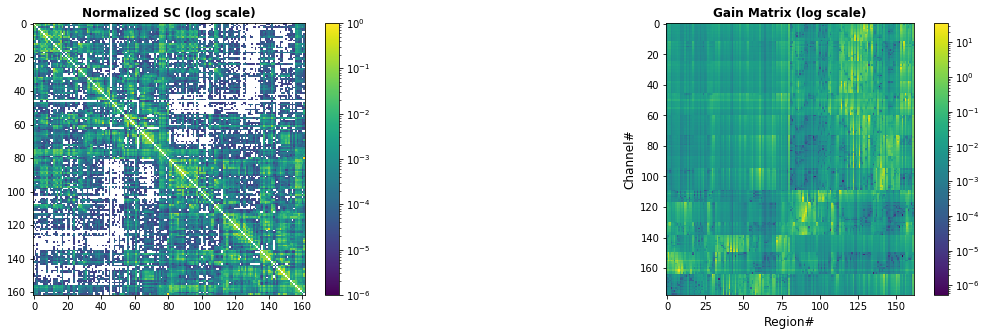

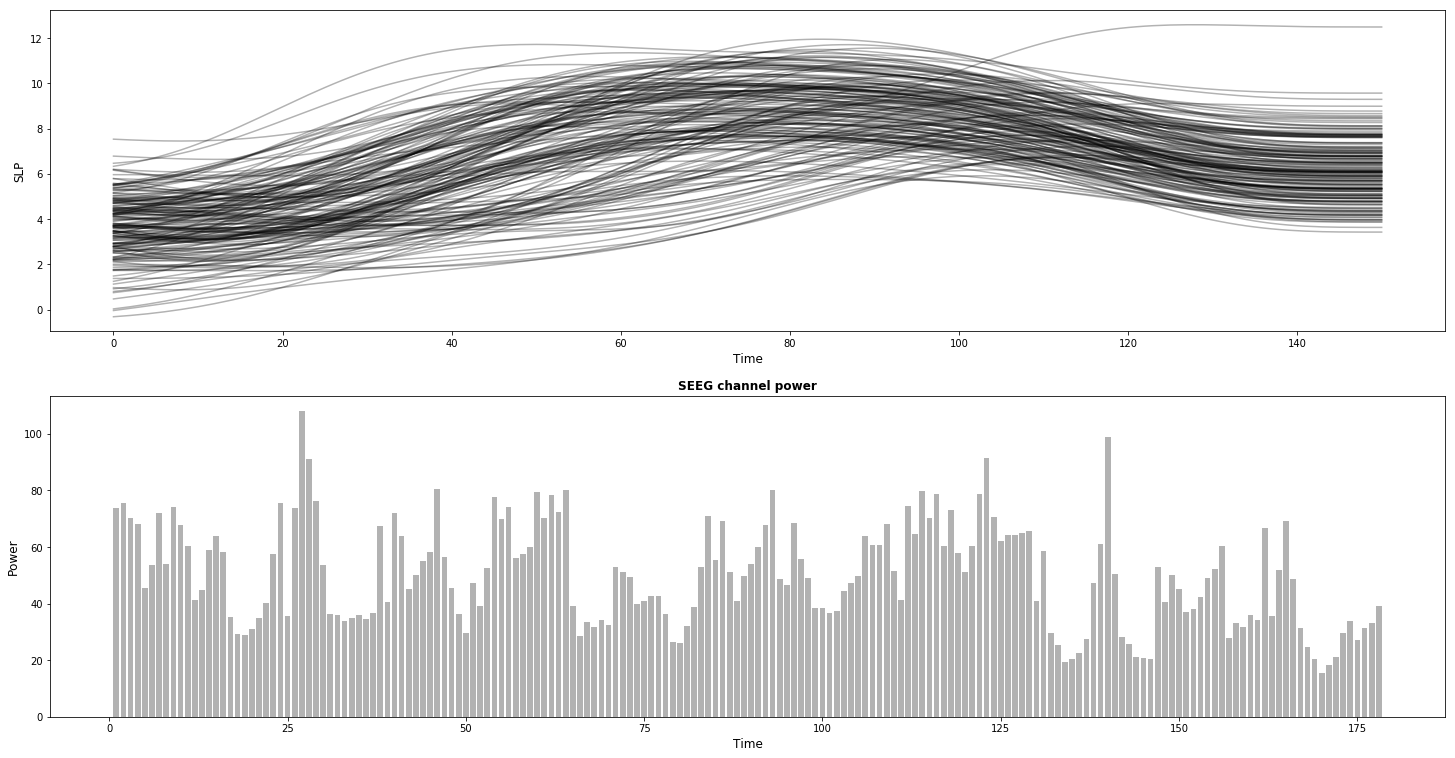

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target_{fname_suffix}.png')
# plt.tight_layout()


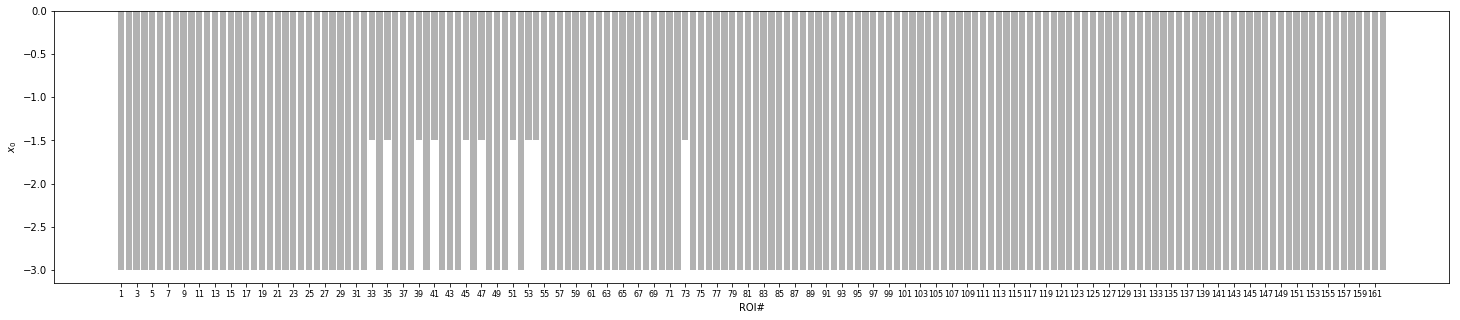

In [13]:
plt.figure(figsize=(25,5))
plt.bar(np.r_[1:data['nn']+1],data['x0_mu'], color='black', alpha=0.3)
plt.xticks(np.r_[1:data['nn']+1:2], fontsize=8);
plt.xlabel('ROI#')
plt.ylabel(r'$x_0$', fontsize=10)
plt.savefig(f'{results_dir}/figures/ez_hyp.png')

In [15]:
#stan_fname = 'vep-snsrfit-ode-nointerp'
stan_fname = 'szr_prpgtn'

x0 = data['x0_mu']
amplitude = 1.0 
offset = 0
K = 1.0
tau0 = 20
eps_slp = 1.0
eps_snsr_pwr = 1.0
x_init = -2.0*np.ones(data['nn'])
z_init = 3.5*np.ones(data['nn'])

param_init = {'x0':x0, 'amplitude':amplitude,
              'offset':offset, 'K':K, 'tau0':tau0, 'x_init':x_init, 'z_init':z_init,
              'eps_slp':eps_slp, 'eps_snsr_pwr':eps_snsr_pwr}

param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

input_Rfile = f'fit_data_{fname_suffix}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [16]:
#%%bash -s "$stan_fname" 

#stancompile.sh $1

In [17]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4


for i in {1..4};
do
srun ./${STAN_FNAME} optimize algorithm=lbfgs tol_param=1e-4 iter=20000 save_iterations=0  \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done

In [37]:
%%file job.sh
#!/bin/bash

#SBATCH --array=1-200
#SBATCH --partition=lowprio

i=$SLURM_ARRAY_TASK_ID

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4

./${STAN_FNAME} optimize algorithm=lbfgs tol_param=1e-4 iter=20000 save_iterations=0  \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log



Writing job.sh


In [36]:
%%bash

sbatch ./job.sh model results input.R fnamesuffix

PARTITION AVAIL  TIMELIMIT  NODES  STATE NODELIST
all*         up 6-00:00:00      4  down* n[15,22-24]
all*         up 6-00:00:00      5    mix n[17,19-21,25]
all*         up 6-00:00:00      1  alloc n18
all*         up 6-00:00:00      3   idle n[07,09,13]
all*         up 6-00:00:00      9   down n[05-06,08,10-12,14,16,26]
dev          up    2:00:00      4   idle n[01-04]
rhu          up 12-00:00:0      4  down* n[15,22-24]
rhu          up 12-00:00:0      6    mix n[17,19-21,25,27]
rhu          up 12-00:00:0      1  alloc n18
rhu          up 12-00:00:0      1   idle n28
rhu          up 12-00:00:0      2   down n[16,26]
lowprio      up 12-00:00:0      4  down* n[15,22-24]
lowprio      up 12-00:00:0      6    mix n[17,19-21,25,27]
lowprio      up 12-00:00:0      1  alloc n18
lowprio      up 12-00:00:0      8   idle n[01-04,07,09,13,28]
lowprio      up 12-00:00:0      9   down n[05-06,08,10-12,14,16,26]


In [39]:
!squeue -u hfw

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
